# Import the kaggle API file

In [1]:
from google.colab import files
files.upload()



Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"ashwinichoudhary","key":"7a28d2104e1d327dfbe9da80314a3d17"}'}

# Rename the Kaggle the file

In [2]:
!mv "kaggle (2).json" kaggle.json


# Moving it to proper directory

In [3]:
import os
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# downloading dataset directly from Kaggle

In [4]:
!kaggle datasets download -d prathumarikeri/indian-sign-language-isl



Dataset URL: https://www.kaggle.com/datasets/prathumarikeri/indian-sign-language-isl
License(s): CC-BY-SA-4.0
 99% 278M/281M [00:17<00:00, 21.0MB/s]
100% 281M/281M [00:17<00:00, 16.5MB/s]


# Unzipping the dataset

In [5]:
import zipfile
with zipfile.ZipFile("indian-sign-language-isl.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")


# Extracting the file from the dataset

In [6]:
base_dir = "/content/dataset/Indian"

image_paths = []
labels = []


for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):

        for image_name in os.listdir(folder_path):
            image_paths.append(os.path.join(folder_path, image_name))
            labels.append(folder_name)


# Making it into Dataframe

In [7]:
# Create a DataFrame
import pandas as pd

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

df


,image_path,label
0,/content/dataset/Indian/P/498.jpg,P
1,/content/dataset/Indian/P/901.jpg,P
2,/content/dataset/Indian/P/908.jpg,P
3,/content/dataset/Indian/P/697.jpg,P
4,/content/dataset/Indian/P/178.jpg,P
...,...,...
42740,/content/dataset/Indian/A/684.jpg,A
42741,/content/dataset/Indian/A/1160.jpg,A
42742,/content/dataset/Indian/A/11.jpg,A
42743,/content/dataset/Indian/A/187.jpg,A


# Slicing the Dataset

Here I sliced my dataset to 20000 images as 40000 images were taking lot of time and resources so I took subset so it can work faster.

In [8]:
import pandas as pd

rows_to_remove = 20000
drop_indices = df.sample(n=rows_to_remove, random_state=42).index

df = df.drop(drop_indices).reset_index(drop=True)

print(df.shape)


(22745, 2)


# Random Image projection

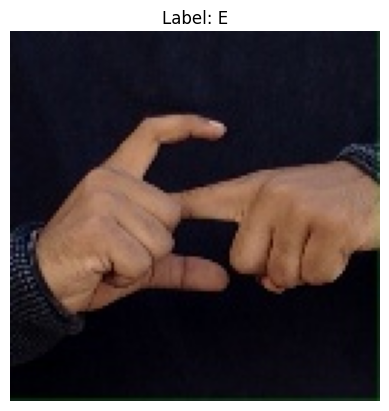

In [9]:
import random
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

def random_image_from_dataframe(df):

    random_row = df.sample(n=1).iloc[0]

    image_path = random_row['image_path']
    label = random_row['label']

    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {label}")
    plt.show()

random_image_from_dataframe(df)


#Splitting the data

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])


# Reducing the dimension of Image

Here I reduced the dimension of the images to 128X128 so that they are easily convulated with less time

In [11]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Data augmentation with grayscale images converted to RGB
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=(0.5, 1.5),
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 18196 validated image filenames belonging to 35 classes.
Found 4549 validated image filenames belonging to 35 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(35, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2
)

# model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


569/569 ━━━━━━━━━━━━━━━━━━━━ 131s 209ms/step - accuracy: 0.0824 - loss: 3.7238 - val_accuracy: 0.0853 - val_loss: 3.9605 - learning_rate: 1.0000e-04
Epoch 2/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 123s 190ms/step - accuracy: 0.2370 - loss: 2.8487 - val_accuracy: 0.2346 - val_loss: 2.7204 - learning_rate: 1.0000e-04
Epoch 3/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 141s 188ms/step - accuracy: 0.3834 - loss: 2.2517 - val_accuracy: 0.3592 - val_loss: 2.2769 - learning_rate: 1.0000e-04
Epoch 4/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 110s 190ms/step - accuracy: 0.5105 - loss: 1.8421 - val_accuracy: 0.5575 - val_loss: 1.4139 - learning_rate: 1.0000e-04
Epoch 5/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 141s 190ms/step - accuracy: 0.5911 - loss: 1.5380 - val_accuracy: 0.6518 - val_loss: 1.3620 - learning_rate: 1.0000e-04
Epoch 6/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 108s 187ms/step - accuracy: 0.6585 - loss: 1.3409 - val_accuracy: 0.6821 - val_loss: 1.2994 - learning_rate: 1.0000e-04
Epoch 7/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 143s 189ms/

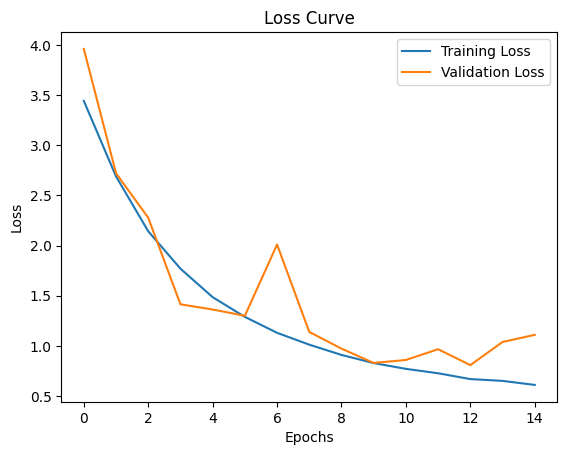

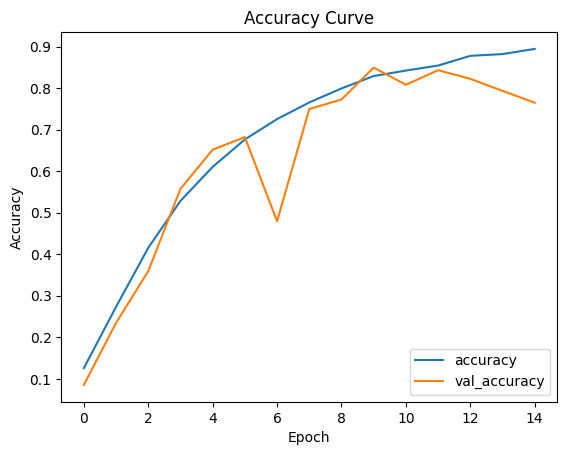

In [13]:
# Loss curve
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend(loc='lower right')
plt.show()

# Predictions

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = test_generator.classes

class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)


143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


# Confusion Matrix

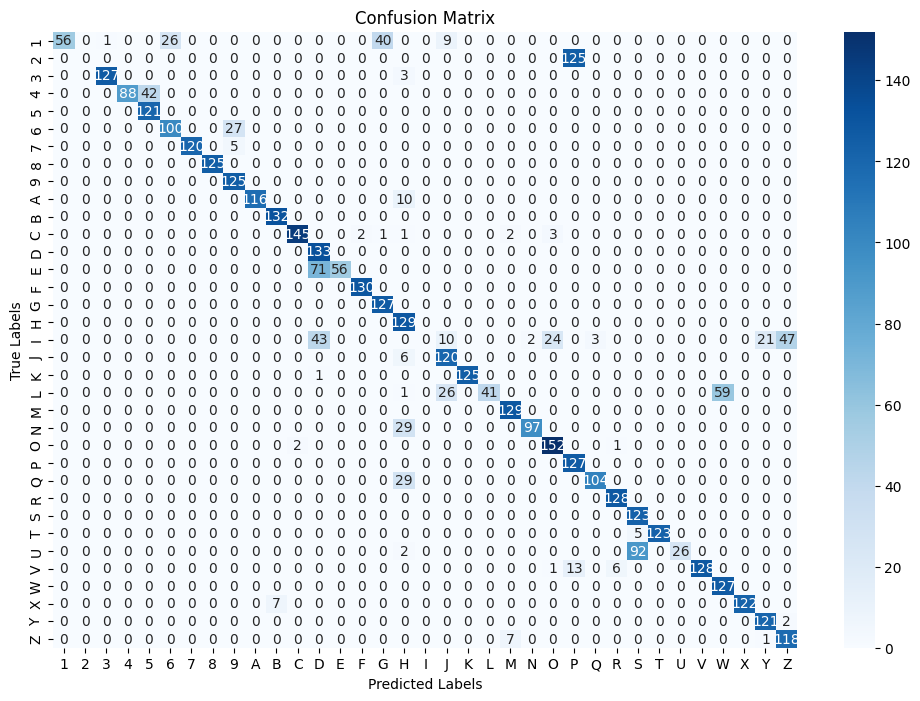

In [15]:

cm = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Classification Report

In [16]:

report = classification_report(true_labels, predicted_classes, target_names=class_names)
print(report)


              precision    recall  f1-score   support

           1       1.00      0.42      0.60       132
           2       0.00      0.00      0.00       125
           3       0.99      0.98      0.98       130
           4       1.00      0.68      0.81       130
           5       0.74      1.00      0.85       121
           6       0.79      0.79      0.79       127
           7       1.00      0.96      0.98       125
           8       1.00      1.00      1.00       125
           9       0.80      1.00      0.89       125
           A       1.00      0.92      0.96       126
           B       0.95      1.00      0.97       132
           C       0.99      0.94      0.96       154
           D       0.54      1.00      0.70       133
           E       1.00      0.44      0.61       127
           F       0.98      1.00      0.99       130
           G       0.76      1.00      0.86       127
           H       0.61      1.00      0.76       129
           I       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
